# Wood moisture classification (wmc) model creation pipeline

The following code is adapted from the FP-AI-SENSING1 application of ST microelectronics

In [1]:
import numpy as np
import os
from tqdm import tqdm
import librosa
import librosa.display
import librosa.util
#from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#import tensorflow as tf
#import keras.utils
#from keras import layers
#from keras import models
#from keras import optimizers
from pickle import dump
import random


import torch
import torch.utils

/home/saverio/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Current version (for reproduction)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("Librosa:", librosa.__version__)

TensorFlow: 2.4.1
Keras: 2.4.3
Librosa: 0.8.1


## Global settings
__Important:__ These settings have to match the ones in the STM32 application.

In [2]:
AUDIO_SAMPLING_FREQUENCY = 48000 # kHz 
NB_FRAMES = 32 # How many columns for the short time fourier transformation
NB_BINS = 30 # Resolution (bins) of one STFT column
HOP_LENGTH = 512 # Jumps between FFT frames
WINDOW_SIZE = HOP_LENGTH*NB_FRAMES + HOP_LENGTH # For one spectrogram column 1024 samples are needed
NB_WINDOWS = 100 # Total number of windwo recorded in one WAV file
FRAME_SIZE = 1024 # Size for one FFT
FREQ_MIN = 5000 # Lowest bin for the columns
TOP_DB = 80 # Cut off of DBs

## 1. Import and convert the data
Load the files from the data directory. The labels for the files are specified in model/dataset/labels.txt.

In [3]:
dataset_dir = './dataset'
fileset_path = path = os.path.join(dataset_dir, 'labels.txt')
fileset = np.loadtxt(fileset_path, dtype=str)

# 3 classes : 0 dry, 1 semiwet, 2 wet
class_names = ['dry', 'semiwet', 'wet']
labels = {
    'dry' : 0,
    'semiwet' : 1,
    'wet' : 2,
}


# x is a list of the recordings and y is a list of the respective labels (targets)
x = []
y = []

# Iteratate over all recordings defined in labels.txt
for file in tqdm(fileset):
    file_path, file_label = file
    file_path = os.path.join(dataset_dir, file_path)
    
    signal, _ = librosa.load(file_path, sr=AUDIO_SAMPLING_FREQUENCY, mono=True, dtype=np.float32)   
    # Cut off total samples because recording takes a bit more samples
    signal = signal[0:NB_WINDOWS*WINDOW_SIZE]
    
    label = labels[file_label]
    
    x.append(signal)
    y.append(label)

100%|██████████| 18/18 [00:00<00:00, 28.22it/s]


AttributeError: module 'librosa.display' has no attribute 'waveplot'

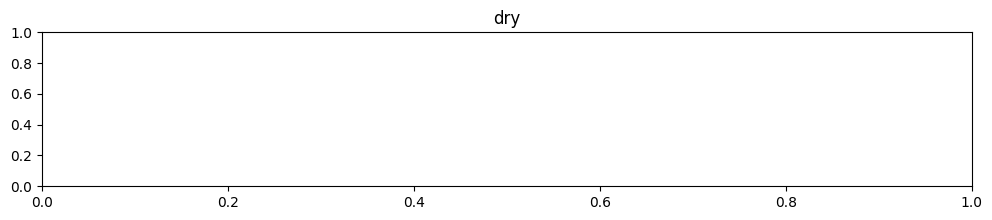

In [4]:
# Check a random sample of first recording
rand = random.randint(0, NB_FRAMES)
recording1 = x[1]
window = recording1[WINDOW_SIZE*rand:WINDOW_SIZE*(rand+1)]

plt.figure(figsize=(12, 2))
plt.title(class_names[y[1]])
librosa.display.waveplot(window, sr=AUDIO_SAMPLING_FREQUENCY)
Audio(window, rate=AUDIO_SAMPLING_FREQUENCY)

## 2. Prepare the data

### 2.1 Slice data into windows
Each audio recording (WAV file) contains the specified number of windows (NB_WINDOWS).

Each window will contain 16,896 samples (32 * 512 + 512) to create a 32 column spectrogram with FRAME_SIZE=1024 and HOP_LENGTH=512.

In [5]:
# Each window will now be an entry in the list
x_windows = []
y_windows = []

# Iteratate over all recordings and create windows
for i in range(len(x)):
    x_tmp = np.asarray(x[i])    
    for k  in range(NB_WINDOWS):
        window = x_tmp[k*WINDOW_SIZE:(k+1)*WINDOW_SIZE]
        x_windows.append(np.transpose(window)) 
    y_windows.append(np.full(NB_WINDOWS, y[i]))
    
# Convert into numpy arrays
x_windows = np.asarray(x_windows)
y_windows = np.asarray(y_windows)

# Reshape labels 
y_windows = y_windows.reshape(y_windows.shape[0]*y_windows.shape[1], )

print("x_windows shape: ", x_windows.shape) # Each window of 16,896 samples can be used to create a spectrogram 
print("y_windows shape: ", y_windows.shape) # Corresponding label for each window


x_windows shape:  (1800, 16896)
y_windows shape:  (1800,)


### 2.2 Preprocess the data into STFT spectrograms
Windows are transformed into the spectrograms of size NB_BINS*NB_FRAMES. A filter bank is created for the FFT columns. The filter bank has to match the one used in the microcontroller.

In [6]:
# Initalize FilterBank for the linear FFT bins
FilterStartIndices = []
FilterStopIndices = []

def FilterBankInit():
    start_idx = 107;
    
    for i in range(NB_BINS):
        FilterStartIndices.append(start_idx);
     
        freq_bin = 5300 + i * 600;

        for j in range(start_idx,int(FRAME_SIZE/2+1)):
            fft_freq = 48000 / 1024 * j;

            if (abs(freq_bin-fft_freq) > 300):
                start_idx = j;
                FilterStopIndices.append(j)
                break;

FilterBankInit()
print(FilterStartIndices)
print(FilterStopIndices)

def FilterBank(STFT):
    S = np.zeros((NB_BINS, 32))
    for i in range(NB_BINS):
        start_idx = FilterStartIndices[i]
        stop_idx = FilterStopIndices[i]

        for k in range(32):
            sum = 0
            for j in range(start_idx, stop_idx):
                sum += STFT[j,k];

            S[i, k] = sum;
    return S

[107, 120, 133, 146, 158, 171, 184, 197, 210, 222, 235, 248, 261, 274, 286, 299, 312, 325, 338, 350, 363, 376, 389, 402, 414, 427, 440, 453, 466, 478]
[120, 133, 146, 158, 171, 184, 197, 210, 222, 235, 248, 261, 274, 286, 299, 312, 325, 338, 350, 363, 376, 389, 402, 414, 427, 440, 453, 466, 478, 491]


In [7]:
# Spectograms of windows which will be the feautures for the neural network
x_features = []
y_features = y_windows

for frame in tqdm(x_windows):
    # Create a STFT spectrogram
    STFT = np.abs(librosa.stft(y=frame, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, window='hann', center=False, dtype=None))
    S = FilterBank(STFT) # Why 513 values????

    
    # Scale according to reference power
    S = S / S.max()
    # Convert to dB
    S_log = librosa.power_to_db(S, top_db=TOP_DB)
    x_features.append(S_log)


# Convert into numpy array
x_features = np.asarray(x_features)

print("x_features shape: ", x_features.shape)

100%|██████████| 1800/1800 [00:14<00:00, 120.07it/s]

x_features shape:  (1800, 30, 32)


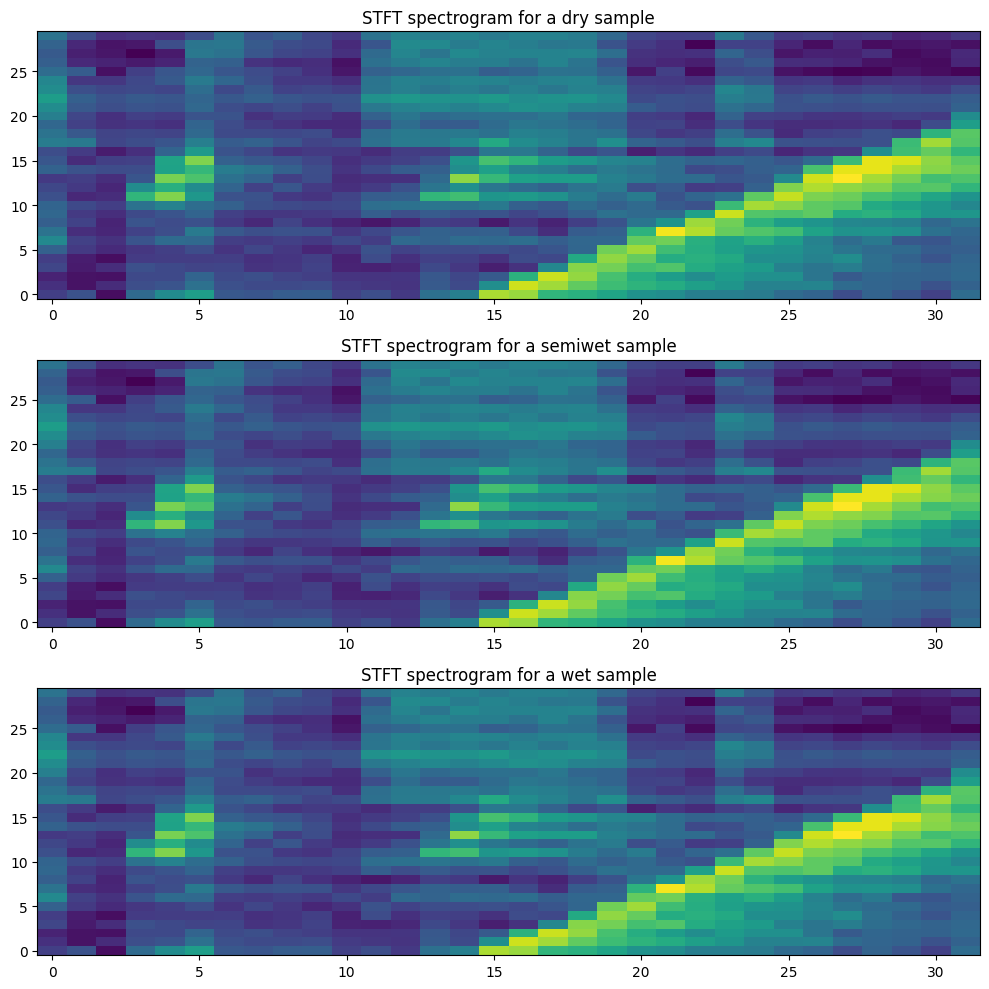

In [8]:
# Plot spectrogram generated for each feature class

# Create grid
grid_x, grid_y = np.mgrid[:32, :30]

plt.figure(figsize=(10, 10))

plt.subplot(311)
first_index = np.argmax(y_windows == 0)
z = x_features[first_index, :, :]
z = z.transpose()
plt.pcolormesh(grid_x, grid_y, z)
plt.title('STFT spectrogram for a ' + class_names[y_features[first_index]] + ' sample')

plt.subplot(312)
second_index = np.argmax(y_windows == 1)
z = x_features[first_index, :, :]
z = z.transpose()
plt.pcolormesh(grid_x, grid_y, z)
plt.title('STFT spectrogram for a ' + class_names[y_features[second_index]] + ' sample')

plt.subplot(313)
third_index = np.argmax(y_windows == 2)
z = x_features[first_index, :, :]
z = z.transpose()
plt.pcolormesh(grid_x, grid_y, z)
plt.title('STFT spectrogram for a ' + class_names[y_features[third_index]] + ' sample')

plt.tight_layout()
plt.show()

### 2.3 Standardize features
Standardize features by removing the mean and scaling to unit variance. Save the feature scalers to model/standardize.

In [9]:
# Flatten features for scaling
x_features_r = np.reshape(x_features, (len(x_features), NB_BINS * NB_FRAMES))

# Create a feature scaler
scaler = preprocessing.StandardScaler().fit(x_features_r)
mean = scaler.mean_
std = scaler.scale_

#  Save feature scaler
standardize_dir = './standardize/'
np.savetxt(standardize_dir + 'mean.csv', mean.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
np.savetxt(standardize_dir + 'std.csv', std.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
dump(scaler, open(standardize_dir + 'scaler.pkl', 'wb'))

# Apply the feature scaler 
x_features_s = scaler.transform(x_features_r)

print("x_features_s shape: ", x_features_s.shape)

x_features_s shape:  (1800, 960)


### 2.4 One hot encoding of labels
Keras requires one hot encoded labels.

In [10]:
def to_categorical(x, n_classes):
    return np.eye(n_classes, dtype='uint8')[x] 

In [11]:
# Convert labels to categorical one-hot encoding
y_features_hot = to_categorical(y_features, n_classes=len(class_names))

print('The shape of the one-hot encoded labels np array is: ' , y_features_hot.shape)

The shape of the one-hot encoded labels np array is:  (1800, 3)


### 2.5 Split data into training, validation and test
Use 25% for testing. The remaining 75% of the features are split in 25% for validation and 75% for training.

In [12]:
#x_train, x_test, y_train, y_test = torch.utils.data.random_split(full_dataset, [train_size, test_size])
x_train, x_test, y_train, y_test = train_test_split(x_features_s,
                                                    y_features_hot,
                                                    test_size=0.25,
                                                    random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

print('Training samples:', x_train.shape)
print('Validation samples:', x_val.shape)
print('Test samples:', x_test.shape)

Training samples: (1012, 960)
Validation samples: (338, 960)
Test samples: (450, 960)


### 2.6 (Optional) Save the features
Save the features to a csv file in a format X-CUBE-AI can understand, that is, for each tensor, the values are in a flattened vector.

In [19]:
#val_dir = './validation/'
#np.savetxt(val_dir + 'x_train.csv', x_train.reshape(len(x_train), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_train.csv', y_train, delimiter=",")
#np.savetxt(val_dir + 'x_val.csv', x_val.reshape(len(x_val), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_val.csv', y_val, delimiter=",")
#np.savetxt(val_dir + 'x_test.csv', x_test.reshape(len(x_test), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_test.csv', y_test, delimiter=",")

## 3 Model

### 3.1 Create and compile model
Build a sequential convolutional network classifier model

In [81]:
model = torch.nn.Sequential() #30x32x1
model.append(torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3, 3))) #28x30x16
model.append(torch.nn.ReLU()) 
model.append(torch.nn.MaxPool2d((2, 2))) #14x15x16
model.append(torch.nn.Conv2d(in_channels = 16, out_channels=16, kernel_size=(3, 3))) #12x13x16
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d((2, 2))) #6x6x16
model.append(torch.nn.Flatten())
model.append(torch.nn.Linear(in_features = 6*6*16,out_features = 9))
model.append(torch.nn.ReLU())
model.append(torch.nn.Linear(in_features = 9, out_features = 3))
model.append(torch.nn.Softmax(-1))

# Print model summary
#model.summary()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=576, out_features=9, bias=True)
  (8): ReLU()
  (9): Linear(in_features=9, out_features=3, bias=True)
  (10): LogSoftmax(dim=-1)
)

In [77]:
# Compile model with choosing a loss and an omptimizer
opt = torch.optim.Adam(params=model.parameters(), lr=0.01)
# TODO: this is technically not the same as keras's categorical cross entropy loss
criterion = torch.nn.CrossEntropyLoss()

###  3.2 Train the model

In [78]:
# Reshape features to include channel
#x_train_r = x_train.reshape(x_train.shape[0], 30, 32, 1)
#x_val_r = x_val.reshape(x_val.shape[0], 30, 32, 1)
#x_test_r = x_test.reshape(x_test.shape[0], 30, 32, 1)

# NOTE: pytorch expects channel as second dimension
x_train_r = x_train.reshape(x_train.shape[0], 1, 30, 32)
x_val_r = x_val.reshape(x_val.shape[0], 1, 30, 32)
x_test_r = x_test.reshape(x_test.shape[0], 1, 30, 32)

In [79]:
def validate(model, criterion, val_input, val_target, device="cpu"):
    output = model(val_input.float().to(device))
    loss = criterion(output, val_target.float().to(device))
    return loss.item()


def train(model, criterion, optimizer, train_input, train_target, val_input, val_target, num_epochs, mini_batch_size, device="cpu"):
    train_input, train_target = train_input.float().to(device), train_target.float().to(device)
    loss_history = {"train_loss":[], "val_loss":[]}
    for e in range(num_epochs):
        print(f"Epoch: {e}")
        avg_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size).float().to(device))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size).float().to(device))
            avg_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            validate_loss = validate(model, criterion, val_input, val_target)
        avg_loss /= (train_input.size(0) // mini_batch_size)
        loss_history["train_loss"].append(avg_loss)
        loss_history["val_loss"].append(validate_loss)
        #loss_history["train_loss"].append((e, avg_loss))
        #loss_history["val_loss"].append((e, validate_loss))
        print("Train Loss:", avg_loss)
        print("Val Loss:", validate_loss)
    return loss_history

In [82]:
# Train the model
#history = model.fit(x_train_r, y_train, validation_data=(x_val_r, y_val),
                    #batch_size=500, epochs=30, verbose=2)

history = train(model, criterion, opt, torch.Tensor(x_train_r), torch.Tensor(y_train), torch.Tensor(x_val_r), torch.Tensor(y_val), num_epochs=30, mini_batch_size=x_train_r.shape[0] // 4)


Epoch: 0


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

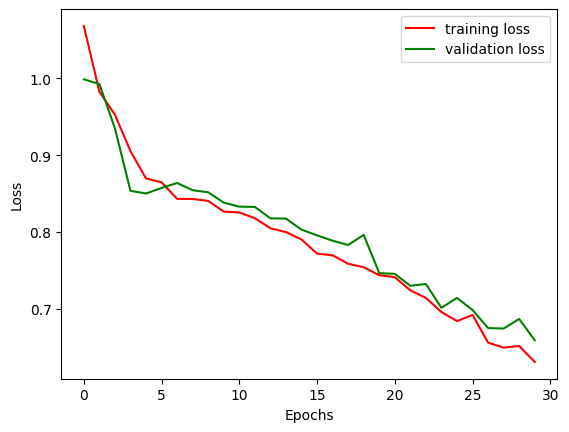

In [74]:
# Plot losses
train_loss = history['train_loss']
val_loss = history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(0, len(train_loss)), train_loss, color='r', label='training loss')
plt.plot(np.arange(0, len(val_loss)), val_loss, color='g', label='validation loss')
plt.legend()

### 3.3 Evaluate Accuracy
Compare how the model performs on the test dataset:

In [ ]:
# Evaluate the model
def evaluate(model, x_test, y_test):
    predictions, targets = list(), list()# loop over all batches in test setfor i, (inputs, targets) in enumerate(test_dl):
    y_pred = model(x_test).detach().numpy()
    res = np.argmax(y_pred, axis = 1) 
    
    # actual output
    targets = targets.numpy().reshape(len(targets, 1))
    
    # store the values in respective lists
    predictions.append(list(res))
    actuals.append(list(targets))
        
    actuals = [val for sublist in np.vstack(list(np.chain(*actuals))) for val in sublist]
    predictions = [val for sublist in np.vstack(list(np.chain(*predictions))) for val in sublist]




In [75]:
print('Evaluate model:')
#results = model.evaluate(x_test_r, y_test)
results = evaluate(model, criterion, torch.Tensor(x_test_r), torch.Tensor(y_test))
print(results)
print('Test loss: {:f}'.format(results[0]))
print('Test accuracy: {:.2f}%'.format(results[1] * 100))

Evaluate model:
0.643123984336853


TypeError: 'float' object is not subscriptable

Accuracy = 68.00%


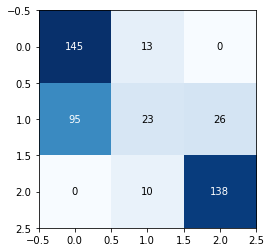

In [26]:
# Plot a confusion matrix
y_pred = model.predict(x_test_r)

y_pred_class_n = np.argmax(y_pred, axis=1)
y_true_class_n = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_class_n, y_pred_class_n)
np.set_printoptions(precision=2)
print("Accuracy = {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(y_true_class_n, y_pred_class_n, labels=[0,1,2])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.imshow(cm, cmap=plt.cm.Blues)

### 3.4 Save the model
When saving the model in a `.h5` file format, the X-CUBE-AI tool can import the pre-trained model and generate an equivalent C model optmized for STM32 devices.

In [ ]:
# Save the model into an HDF5 file ‘model.h5’
model.save('wmc.h5')